In [1]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import torch.nn as nn
#from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models

import torchvision.transforms as transforms

In [3]:
from functions import(import_train_folder_dataset,
                      Data,
                      import_test_folder_dataset,
                      Data_test,
                      plot_loss_accuracy,
                      save_model,
                      save_metrics,
                      save_predictions_as_csv
                     )

# Variables

In [4]:
model_epochs = 100 # 100

lr = 0.006 # Learning rate.
                            
#torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 50 epochs

model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/CheckPoints/"
PATH = "D:\\Personal\\Alex\\Uni\\MS IA\\2 Curso\\Fall 2022\Artificial Intelligence\\Projects\\Project 1\\Models Save\\GoogleNet_CAM-Plus-ImgClass_v2\\"

# Path of the Data files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped_v2/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped_v2/Test"

cuda


# Import Data

In [5]:

img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((400, 400)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


## Train-Val data

In [6]:
# Import the data
train_data, train_labels = import_train_folder_dataset(train_data_path)
print("Train Dim of Data: ", train_data.shape)
print("Train Dim of Lables: ", train_labels.shape)

Train Dim of Data:  (1149, 400, 400, 3)
Train Dim of Lables:  (1149,)


In [7]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=1)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 400, 400, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 400, 400, 3)
Dim of y_test:  (115,)


In [8]:
# Create the dataset object
train_Dataset = Data(X_train, y_train, img_transform_val) # img_transform
val_Dataset = Data(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [9]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

## Test Data

In [10]:
# Import the data
test_data, test_names = import_test_folder_dataset(test_data_path)
print("Test Dim of Data: ", test_data.shape)
print("Test Dim of Lables: ", test_names.shape)

Test Dim of Data:  (380, 400, 400, 3)
Test Dim of Lables:  (380,)


In [11]:
# Create the dataset object
test_Dataset = Data_test(test_data, test_names, img_transform_val) # img_transform

print("Test len: ",len(test_Dataset))

Test len:  380


In [12]:
# Create the dataloaders
test_loader = DataLoader(
    test_Dataset, 
    batch_size=1,             
    shuffle=False)

# Create Model

In [13]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self, model):
        super(ClassificationNet, self).__init__()
        # get the pretrained googlenet network
        #self.googlenet = models.googlenet(pretrained=True)
        #self.resnet50 = models.resnet50(pretrained=True)
        
        # Get the feature extractor
        self.model_fe = nn.Sequential(*list(model.children())[:-1])
        #self.resnet50_fe = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Flatten the FE output
        self.flatten = nn.Flatten()
        
        # Add a clissifier
        self.last_classifier =  nn.Linear(in_features=147456, out_features=4)
        
    def forward(self, x): 
        #x = self.resnet50_fe(x)
        x = self.model_fe(x)
        
        x = self.flatten(x)
        
        x = self.last_classifier(x)
        
        return x

modelpy = ClassificationNet(model = models.densenet121(pretrained=True)).to(device)

# Loss Function
criterion_2 = nn.CrossEntropyLoss()

# Optimizer    
trainable_parameters_2 = filter(lambda p: p.requires_grad, modelpy.parameters())
#optimizer_2 = torch.optim.Adam(params=trainable_parameters_2, lr=lr)
optimizer_2 = torch.optim.SGD(params=trainable_parameters_2, lr=lr, momentum=1e-5) 

# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0

modelpy

D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ClassificationNet(
  (model_fe): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, moment

In [14]:
# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt_m2.pth"):
        print("Loading saved checkpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt_m2.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optimizer_2.load_state_dict(checkpoint['optimizer_state_dict'])
        model_epoch_m2_check = checkpoint['epoch']
        criterion_2 = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {model_epoch_m2_check}")


In [15]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 7543684


# Train Model

In [16]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"]=lr

Epoch 1 of 100


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


train loss:  0.9528095457176867
Val loss:  2.234008897905764
train accuracy:  0.4748549323017408
Val accuracy:  0.5304347826086957
Best model at the moment with Val_acc 53.04, saving...
Current time: 4.521 minutes. Time expected till completion: 447.596 minutes
Epoch 2 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  1.371293738372696
Val loss:  1.976960905738499
train accuracy:  0.4816247582205029
Val accuracy:  0.391304347826087
Current time: 6.507 minutes. Time expected till completion: 318.835 minutes
Epoch 3 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  1.573442575779367
Val loss:  1.9894601448722509
train accuracy:  0.4700193423597679
Val accuracy:  0.4434782608695652
Current time: 8.489 minutes. Time expected till completion: 274.473 minutes
Epoch 4 of 100


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


train loss:  1.7771662667899115
Val loss:  2.4739383054816204
train accuracy:  0.49032882011605416
Val accuracy:  0.4782608695652174
Current time: 10.466 minutes. Time expected till completion: 251.178 minutes
Epoch 5 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  1.7604768568275198
Val loss:  3.531387876427692
train accuracy:  0.5058027079303675
Val accuracy:  0.41739130434782606
Current time: 12.448 minutes. Time expected till completion: 236.516 minutes
Epoch 6 of 100


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


train loss:  1.8303625981469334
Val loss:  2.7064813821212104
train accuracy:  0.4912959381044487
Val accuracy:  0.5217391304347826
Current time: 14.422 minutes. Time expected till completion: 225.944 minutes
Epoch 7 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  1.773647485203623
Val loss:  1.9663222022678541
train accuracy:  0.52321083172147
Val accuracy:  0.5043478260869565
Current time: 16.390 minutes. Time expected till completion: 217.759 minutes
Epoch 8 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  1.773450775169254
Val loss:  3.3108293574789296
train accuracy:  0.5261121856866537
Val accuracy:  0.5217391304347826
Current time: 18.368 minutes. Time expected till completion: 211.233 minutes
Epoch 9 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  1.9379510718976045
Val loss:  9.092605358621348
train accuracy:  0.5106382978723404
Val accuracy:  0.40869565217391307
Current time: 20.343 minutes. Time expected till completion: 205.689 minutes
Epoch 10 of 100


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


train loss:  1.7699324100179692
Val loss:  5.687287358615709
train accuracy:  0.5270793036750484
Val accuracy:  0.4956521739130435
Current time: 22.325 minutes. Time expected till completion: 200.923 minutes
Epoch 11 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  2.0590070763015595
Val loss:  1.8721156147920777
train accuracy:  0.5512572533849129
Val accuracy:  0.46956521739130436
Current time: 24.299 minutes. Time expected till completion: 196.598 minutes
Epoch 12 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  2.1488084012112663
Val loss:  2.416082952333533
train accuracy:  0.5454545454545454
Val accuracy:  0.5217391304347826
Current time: 26.283 minutes. Time expected till completion: 192.745 minutes
Epoch 13 of 100


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


train loss:  1.581633949850468
Val loss:  7.81057825503142
train accuracy:  0.562862669245648
Val accuracy:  0.4260869565217391
Current time: 28.268 minutes. Time expected till completion: 189.177 minutes
Epoch 14 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  2.0192835349031153
Val loss:  1.7207462939302154
train accuracy:  0.5009671179883946
Val accuracy:  0.4956521739130435
Current time: 30.244 minutes. Time expected till completion: 185.782 minutes
Epoch 15 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  1.8130563615102544
Val loss:  2.8235168488129325
train accuracy:  0.5425531914893617
Val accuracy:  0.46956521739130436
Current time: 32.233 minutes. Time expected till completion: 182.652 minutes
Epoch 16 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  1.849635890794907
Val loss:  1.436678866199825
train accuracy:  0.5251450676982592
Val accuracy:  0.5826086956521739
Best model at the moment with Val_acc 58.26, saving...
Current time: 34.212 minutes. Time expected till completion: 179.614 minutes
Epoch 17 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  1.5681382395430445
Val loss:  3.3314116488332335
train accuracy:  0.5667311411992263
Val accuracy:  0.48695652173913045
Current time: 36.194 minutes. Time expected till completion: 176.714 minutes
Epoch 18 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  1.6565596315666593
Val loss:  6.808864464967147
train accuracy:  0.5812379110251451
Val accuracy:  0.5043478260869565
Current time: 38.174 minutes. Time expected till completion: 173.902 minutes
Epoch 19 of 100


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


train loss:  2.131184315586344
Val loss:  3.1797871548196546
train accuracy:  0.5386847195357833
Val accuracy:  0.3739130434782609
Current time: 40.153 minutes. Time expected till completion: 171.178 minutes
Epoch 20 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  1.9810905713638438
Val loss:  1.374252804465916
train accuracy:  0.5386847195357833
Val accuracy:  0.5130434782608696
Current time: 42.135 minutes. Time expected till completion: 168.540 minutes
Epoch 21 of 100


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


train loss:  2.1636332467966666
Val loss:  2.972055837382441
train accuracy:  0.5367504835589942
Val accuracy:  0.4956521739130435
Current time: 44.110 minutes. Time expected till completion: 165.938 minutes
Epoch 22 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  2.3494892738510926
Val loss:  3.365704305793928
train accuracy:  0.5106382978723404
Val accuracy:  0.5217391304347826
Current time: 46.101 minutes. Time expected till completion: 163.451 minutes
Epoch 23 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  1.920425987335884
Val loss:  0.9984957487686821
train accuracy:  0.5512572533849129
Val accuracy:  0.45217391304347826
Current time: 48.077 minutes. Time expected till completion: 160.955 minutes
Epoch 24 of 100


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


train loss:  2.200118424352871
Val loss:  3.6605011566825536
train accuracy:  0.5096711798839458
Val accuracy:  0.5391304347826087
Current time: 50.060 minutes. Time expected till completion: 158.524 minutes
Epoch 25 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  1.7194053024588631
Val loss:  4.904427808264027
train accuracy:  0.5686653771760155
Val accuracy:  0.48695652173913045
Current time: 52.034 minutes. Time expected till completion: 156.101 minutes
Epoch 26 of 100


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


train loss:  1.8142992301665721
Val loss:  1.878330015099567
train accuracy:  0.6054158607350096
Val accuracy:  0.5130434782608696
Current time: 54.017 minutes. Time expected till completion: 153.741 minutes
Epoch 27 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  1.6542468139128508
Val loss:  1.600545955222586
train accuracy:  0.6025145067698259
Val accuracy:  0.48695652173913045
Current time: 55.993 minutes. Time expected till completion: 151.387 minutes
Epoch 28 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  1.7924365532600588
Val loss:  1.8922597454941792
train accuracy:  0.5880077369439072
Val accuracy:  0.46956521739130436
Current time: 57.972 minutes. Time expected till completion: 149.072 minutes
Epoch 29 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  1.296953907086554
Val loss:  29.66316328877988
train accuracy:  0.6450676982591876
Val accuracy:  0.5565217391304348
Current time: 59.947 minutes. Time expected till completion: 146.766 minutes
Epoch 30 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  1.3165271615576202
Val loss:  2.523298292056374
train accuracy:  0.6334622823984526
Val accuracy:  0.6086956521739131
Best model at the moment with Val_acc 60.87, saving...
Current time: 61.924 minutes. Time expected till completion: 144.489 minutes
Epoch 31 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  1.305363152548748
Val loss:  16.233154340412305
train accuracy:  0.660541586073501
Val accuracy:  0.4956521739130435
Current time: 63.896 minutes. Time expected till completion: 142.221 minutes
Epoch 32 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  1.0035963159084922
Val loss:  4.67953951306965
train accuracy:  0.6856866537717602
Val accuracy:  0.5478260869565217
Current time: 65.869 minutes. Time expected till completion: 139.971 minutes
Epoch 33 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  0.8450274072457368
Val loss:  2.9473198455312977
train accuracy:  0.688588007736944
Val accuracy:  0.41739130434782606
Current time: 67.843 minutes. Time expected till completion: 137.743 minutes
Epoch 34 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  0.9903400786495262
Val loss:  38.53039515951406
train accuracy:  0.6663442940038685
Val accuracy:  0.34782608695652173
Current time: 69.818 minutes. Time expected till completion: 135.530 minutes
Epoch 35 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  1.1024289285116495
Val loss:  2.577408185982621
train accuracy:  0.6441005802707931
Val accuracy:  0.48695652173913045
Current time: 71.790 minutes. Time expected till completion: 133.324 minutes
Epoch 36 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.9814065510201802
Val loss:  4.710121992359991
train accuracy:  0.6856866537717602
Val accuracy:  0.5043478260869565
Current time: 73.762 minutes. Time expected till completion: 131.132 minutes
Epoch 37 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.8700423880109649
Val loss:  2.9515914377958876
train accuracy:  0.718568665377176
Val accuracy:  0.5391304347826087
Current time: 75.734 minutes. Time expected till completion: 128.952 minutes
Epoch 38 of 100


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


train loss:  0.7553553580256858
Val loss:  5.819261119676673
train accuracy:  0.7088974854932302
Val accuracy:  0.4608695652173913
Current time: 77.710 minutes. Time expected till completion: 126.790 minutes
Epoch 39 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  1.0718715067897029
Val loss:  4.586498400957688
train accuracy:  0.6634429400386848
Val accuracy:  0.5130434782608696
Current time: 79.685 minutes. Time expected till completion: 124.635 minutes
Epoch 40 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  1.008817994591911
Val loss:  4.174862679191258
train accuracy:  0.7079303675048356
Val accuracy:  0.5652173913043478
Current time: 81.663 minutes. Time expected till completion: 122.495 minutes
Epoch 41 of 100


100%|██████████| 15/15 [00:04<00:00,  3.19it/s]


train loss:  0.7576649231930407
Val loss:  5.487923101238582
train accuracy:  0.7214700193423598
Val accuracy:  0.5478260869565217
Current time: 83.657 minutes. Time expected till completion: 120.384 minutes
Epoch 42 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  0.8346077391103
Val loss:  3.98507489108521
train accuracy:  0.7021276595744681
Val accuracy:  0.5217391304347826
Current time: 85.632 minutes. Time expected till completion: 118.254 minutes
Epoch 43 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  0.4042072124654586
Val loss:  3.3517242903294773
train accuracy:  0.7843326885880078
Val accuracy:  0.5478260869565217
Current time: 87.614 minutes. Time expected till completion: 116.139 minutes
Epoch 44 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  0.49120127741846353
Val loss:  4.964467089979545
train accuracy:  0.7862669245647969
Val accuracy:  0.5652173913043478
Current time: 89.596 minutes. Time expected till completion: 114.032 minutes
Epoch 45 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  0.5183830921377554
Val loss:  6.213711518826692
train accuracy:  0.7959381044487428
Val accuracy:  0.5130434782608696
Current time: 91.568 minutes. Time expected till completion: 111.916 minutes
Epoch 46 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  0.5030506234707939
Val loss:  3.301254043371781
train accuracy:  0.8210831721470019
Val accuracy:  0.591304347826087
Current time: 93.549 minutes. Time expected till completion: 109.819 minutes
Epoch 47 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  0.4196602554989313
Val loss:  3.646779724113319
train accuracy:  0.8017408123791102
Val accuracy:  0.6
Current time: 95.521 minutes. Time expected till completion: 107.715 minutes
Epoch 48 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  0.4368280284172857
Val loss:  2.885013854596701
train accuracy:  0.816247582205029
Val accuracy:  0.6
Current time: 97.496 minutes. Time expected till completion: 105.621 minutes
Epoch 49 of 100


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


train loss:  0.3880279860228197
Val loss:  4.364934653821199
train accuracy:  0.8201160541586073
Val accuracy:  0.5217391304347826
Current time: 99.473 minutes. Time expected till completion: 103.533 minutes
Epoch 50 of 100


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


train loss:  0.2765003353997916
Val loss:  2.595801952610845
train accuracy:  0.8172147001934236
Val accuracy:  0.5478260869565217
Current time: 101.456 minutes. Time expected till completion: 101.456 minutes
Epoch 51 of 100


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


train loss:  0.25916494318817085
Val loss:  2.2684569643891375
train accuracy:  0.8288201160541586
Val accuracy:  0.5565217391304348
Current time: 103.447 minutes. Time expected till completion: 99.390 minutes
Epoch 52 of 100


100%|██████████| 15/15 [00:04<00:00,  3.22it/s]


train loss:  0.1588993170374555
Val loss:  2.5943886562534
train accuracy:  0.8713733075435203
Val accuracy:  0.5304347826086957
Current time: 105.450 minutes. Time expected till completion: 97.339 minutes
Epoch 53 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  0.20995809813946947
Val loss:  1.6870683557313422
train accuracy:  0.8868471953578336
Val accuracy:  0.6173913043478261
Best model at the moment with Val_acc 61.74, saving...
Current time: 107.473 minutes. Time expected till completion: 95.306 minutes
Epoch 54 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  0.12726407425010147
Val loss:  1.9676068855368574
train accuracy:  0.8945841392649904
Val accuracy:  0.5739130434782609
Current time: 109.879 minutes. Time expected till completion: 93.601 minutes
Epoch 55 of 100


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


train loss:  0.15887797500805698
Val loss:  2.278078468467878
train accuracy:  0.8965183752417795
Val accuracy:  0.6521739130434783
Best model at the moment with Val_acc 65.22, saving...
Current time: 111.886 minutes. Time expected till completion: 91.543 minutes
Epoch 56 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  0.10666585867456263
Val loss:  2.0688132742176886
train accuracy:  0.9032882011605415
Val accuracy:  0.6
Current time: 113.874 minutes. Time expected till completion: 89.472 minutes
Epoch 57 of 100


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


train loss:  0.16840616232541006
Val loss:  3.553098843457258
train accuracy:  0.9100580270793037
Val accuracy:  0.5304347826086957
Current time: 115.857 minutes. Time expected till completion: 87.401 minutes
Epoch 58 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  0.16875522100102053
Val loss:  2.341203870413744
train accuracy:  0.9129593810444874
Val accuracy:  0.6347826086956522
Current time: 117.853 minutes. Time expected till completion: 85.342 minutes
Epoch 59 of 100


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


train loss:  0.142249851519
Val loss:  2.3938162560048313
train accuracy:  0.9061895551257253
Val accuracy:  0.591304347826087
Current time: 119.836 minutes. Time expected till completion: 83.276 minutes
Epoch 60 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  0.1454252047962264
Val loss:  2.4037366566450697
train accuracy:  0.8984526112185687
Val accuracy:  0.5739130434782609
Current time: 121.812 minutes. Time expected till completion: 81.208 minutes
Epoch 61 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  0.18670932535619422
Val loss:  4.032009522811226
train accuracy:  0.9061895551257253
Val accuracy:  0.4608695652173913
Current time: 123.788 minutes. Time expected till completion: 79.143 minutes
Epoch 62 of 100


100%|██████████| 15/15 [00:04<00:00,  3.35it/s]


train loss:  0.22173800452164105
Val loss:  2.924192011239432
train accuracy:  0.8936170212765957
Val accuracy:  0.5391304347826087
Current time: 125.770 minutes. Time expected till completion: 77.085 minutes
Epoch 63 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  0.14349074509110019
Val loss:  2.0553569868854855
train accuracy:  0.9003868471953579
Val accuracy:  0.6086956521739131
Current time: 127.755 minutes. Time expected till completion: 75.031 minutes
Epoch 64 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  0.09372853399985057
Val loss:  2.9969772276671036
train accuracy:  0.925531914893617
Val accuracy:  0.5652173913043478
Current time: 129.731 minutes. Time expected till completion: 72.974 minutes
Epoch 65 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  0.08449682737933098
Val loss:  2.5158815263095122
train accuracy:  0.9381044487427466
Val accuracy:  0.6173913043478261
Current time: 131.712 minutes. Time expected till completion: 70.922 minutes
Epoch 66 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  0.10206129537126588
Val loss:  3.269393902060667
train accuracy:  0.9245647969052224
Val accuracy:  0.6
Current time: 133.700 minutes. Time expected till completion: 68.876 minutes
Epoch 67 of 100


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


train loss:  0.09220851727106927
Val loss:  1.7118527039237645
train accuracy:  0.9148936170212766
Val accuracy:  0.5652173913043478
Current time: 135.688 minutes. Time expected till completion: 66.832 minutes
Epoch 68 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  0.17625266940901077
Val loss:  3.4503280176386317
train accuracy:  0.9148936170212766
Val accuracy:  0.6260869565217392
Current time: 137.675 minutes. Time expected till completion: 64.788 minutes
Epoch 69 of 100


100%|██████████| 15/15 [00:04<00:00,  3.26it/s]


train loss:  0.11253898334892819
Val loss:  1.668918300970741
train accuracy:  0.9284332688588007
Val accuracy:  0.6086956521739131
Current time: 139.677 minutes. Time expected till completion: 62.753 minutes
Epoch 70 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  0.08476688186336166
Val loss:  2.7869119663925273
train accuracy:  0.9410058027079303
Val accuracy:  0.5739130434782609
Current time: 141.677 minutes. Time expected till completion: 60.719 minutes
Epoch 71 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  0.10944947381059508
Val loss:  2.7161035029784495
train accuracy:  0.9206963249516441
Val accuracy:  0.6347826086956522
Current time: 143.653 minutes. Time expected till completion: 58.675 minutes
Epoch 72 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  0.08214957930515338
Val loss:  2.101755692647851
train accuracy:  0.9323017408123792
Val accuracy:  0.5565217391304348
Current time: 145.626 minutes. Time expected till completion: 56.632 minutes
Epoch 73 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  0.1166092297995323
Val loss:  2.1825271938158117
train accuracy:  0.9352030947775629
Val accuracy:  0.5652173913043478
Current time: 147.601 minutes. Time expected till completion: 54.592 minutes
Epoch 74 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.05041308999222532
Val loss:  2.4425414082796677
train accuracy:  0.9506769825918762
Val accuracy:  0.5739130434782609
Current time: 149.572 minutes. Time expected till completion: 52.552 minutes
Epoch 75 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.04992462797238471
Val loss:  1.6806648088538128
train accuracy:  0.9506769825918762
Val accuracy:  0.5565217391304348
Current time: 151.544 minutes. Time expected till completion: 50.515 minutes
Epoch 76 of 100


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


train loss:  0.042489665765534375
Val loss:  2.093969873241756
train accuracy:  0.9584139264990329
Val accuracy:  0.591304347826087
Current time: 153.521 minutes. Time expected till completion: 48.480 minutes
Epoch 77 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.05625569522830259
Val loss:  3.8845285892486574
train accuracy:  0.9574468085106383
Val accuracy:  0.5478260869565217
Current time: 155.494 minutes. Time expected till completion: 46.446 minutes
Epoch 78 of 100


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


train loss:  0.11993919635124825
Val loss:  3.2641058279120405
train accuracy:  0.9458413926499033
Val accuracy:  0.5826086956521739
Current time: 157.486 minutes. Time expected till completion: 44.419 minutes
Epoch 79 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  0.06028963275594691
Val loss:  1.3310985707718392
train accuracy:  0.9584139264990329
Val accuracy:  0.6260869565217392
Current time: 159.464 minutes. Time expected till completion: 42.389 minutes
Epoch 80 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  0.0449887856052619
Val loss:  1.9627683986788211
train accuracy:  0.9709864603481625
Val accuracy:  0.6260869565217392
Current time: 161.441 minutes. Time expected till completion: 40.360 minutes
Epoch 81 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  0.03881043816453193
Val loss:  1.6640471952117009
train accuracy:  0.9661508704061895
Val accuracy:  0.6086956521739131
Current time: 163.418 minutes. Time expected till completion: 38.333 minutes
Epoch 82 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  0.11345886710248912
Val loss:  1.7213955213437262
train accuracy:  0.9516441005802708
Val accuracy:  0.6173913043478261
Current time: 165.395 minutes. Time expected till completion: 36.306 minutes
Epoch 83 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  0.0754676594281209
Val loss:  2.229131811598073
train accuracy:  0.9584139264990329
Val accuracy:  0.5739130434782609
Current time: 167.371 minutes. Time expected till completion: 34.281 minutes
Epoch 84 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  0.054429662232882904
Val loss:  2.414687644729755
train accuracy:  0.9555125725338491
Val accuracy:  0.6347826086956522
Current time: 169.347 minutes. Time expected till completion: 32.257 minutes
Epoch 85 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  0.021338057265501597
Val loss:  2.633667085222576
train accuracy:  0.9758220502901354
Val accuracy:  0.5478260869565217
Current time: 171.324 minutes. Time expected till completion: 30.234 minutes
Epoch 86 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  0.03521695562761185
Val loss:  1.9906758601250856
train accuracy:  0.9593810444874274
Val accuracy:  0.5652173913043478
Current time: 173.300 minutes. Time expected till completion: 28.212 minutes
Epoch 87 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  0.07180057107151051
Val loss:  2.503048946416896
train accuracy:  0.9468085106382979
Val accuracy:  0.6086956521739131
Current time: 175.275 minutes. Time expected till completion: 26.191 minutes
Epoch 88 of 100


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


train loss:  0.06293366361200645
Val loss:  2.469020594721255
train accuracy:  0.9593810444874274
Val accuracy:  0.5739130434782609
Current time: 177.252 minutes. Time expected till completion: 24.171 minutes
Epoch 89 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  0.049384628020477675
Val loss:  2.1380960920582646
train accuracy:  0.9622823984526112
Val accuracy:  0.6347826086956522
Current time: 179.228 minutes. Time expected till completion: 22.152 minutes
Epoch 90 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  0.034154467092397806
Val loss:  3.019314411671265
train accuracy:  0.9709864603481625
Val accuracy:  0.6173913043478261
Current time: 181.203 minutes. Time expected till completion: 20.134 minutes
Epoch 91 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.07777197447943168
Val loss:  4.902591672150985
train accuracy:  0.9709864603481625
Val accuracy:  0.5478260869565217
Current time: 183.177 minutes. Time expected till completion: 18.116 minutes
Epoch 92 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  0.09450315400875642
Val loss:  1.6342989268510237
train accuracy:  0.9458413926499033
Val accuracy:  0.5826086956521739
Current time: 185.153 minutes. Time expected till completion: 16.100 minutes
Epoch 93 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  0.07475699993260268
Val loss:  1.9537306938482368
train accuracy:  0.9661508704061895
Val accuracy:  0.5826086956521739
Current time: 187.130 minutes. Time expected till completion: 14.085 minutes
Epoch 94 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  0.05217747458966903
Val loss:  2.3617308398951655
train accuracy:  0.9642166344294004
Val accuracy:  0.5652173913043478
Current time: 189.105 minutes. Time expected till completion: 12.071 minutes
Epoch 95 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  0.058451997283240235
Val loss:  2.0612491356178553
train accuracy:  0.960348162475822
Val accuracy:  0.6086956521739131
Current time: 191.081 minutes. Time expected till completion: 10.057 minutes
Epoch 96 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.04559041790061317
Val loss:  1.8281488356382951
train accuracy:  0.9661508704061895
Val accuracy:  0.6434782608695652
Current time: 193.056 minutes. Time expected till completion: 8.044 minutes
Epoch 97 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.03874820362028143
Val loss:  2.037214612442514
train accuracy:  0.971953578336557
Val accuracy:  0.6
Current time: 195.032 minutes. Time expected till completion: 6.032 minutes
Epoch 98 of 100


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


train loss:  0.025124968392946315
Val loss:  1.844094921907653
train accuracy:  0.9796905222437138
Val accuracy:  0.6173913043478261
Current time: 197.009 minutes. Time expected till completion: 4.021 minutes
Epoch 99 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.03256912389244264
Val loss:  1.7834562675136587
train accuracy:  0.9806576402321083
Val accuracy:  0.6521739130434783
Current time: 198.982 minutes. Time expected till completion: 2.010 minutes
Epoch 100 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  0.02685378806051254
Val loss:  2.244982808828354
train accuracy:  0.9700193423597679
Val accuracy:  0.6260869565217392
Saving model 2 checkpoint


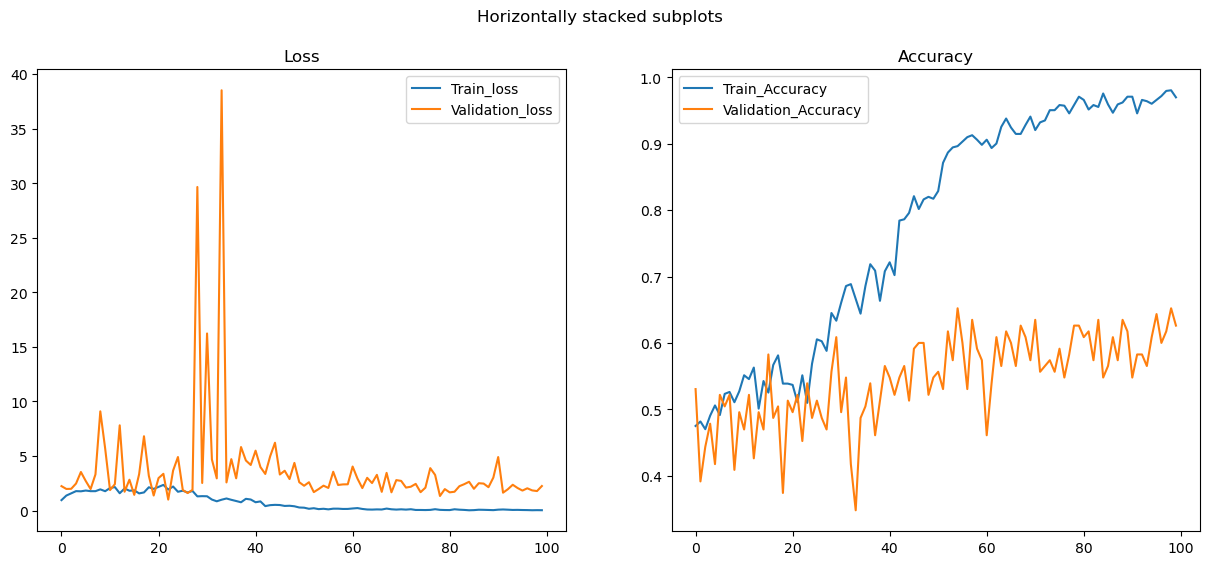

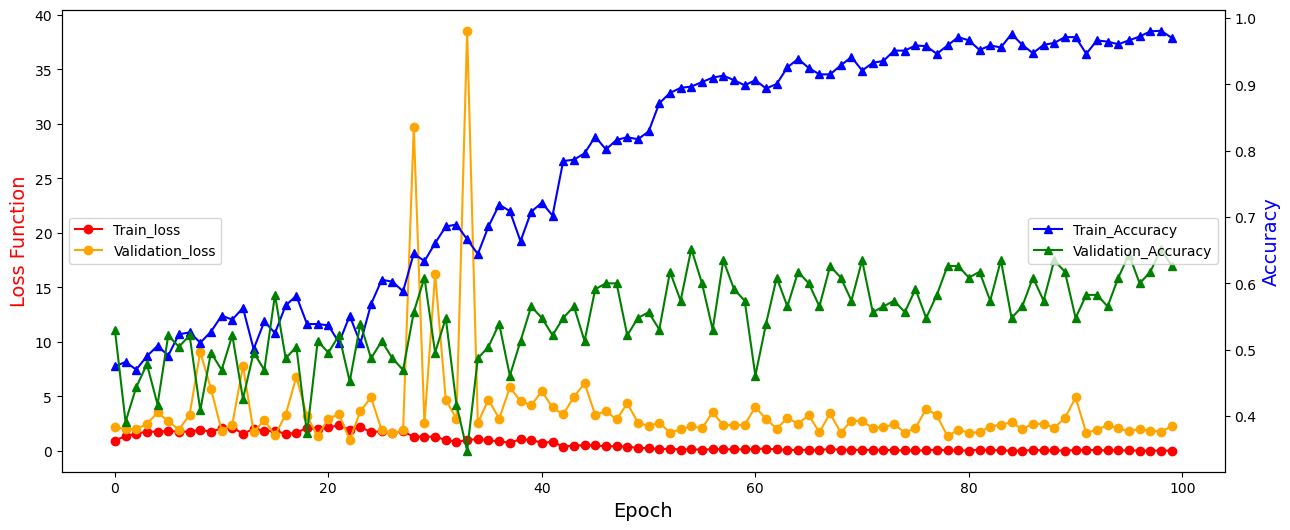

Current time: 201.285 minutes. Time expected till completion: 0.000 minutes
Finished training in: 201.286 minutes


In [17]:

best_model_val_acc = -1

train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy_m2.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy_m2.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()

# count time
start = time.time()
for epoch in range(model_epoch_m2_check, model_epochs):
    # Print current epoch
    print(f"Epoch {epoch + 1} of {model_epochs}")
    
    if(epoch%10 == 0):
        update_optimizer(optimizer_2, 0.001)
        
    ############################################################################
    ################################ Train model ############################### 
    ############################################################################
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # Optimize second model
        
        #create the output from the CNN base on the give batch images
        out_m2 = modelpy(images)
        # count the loss function 
        loss_2 = criterion_2(out_m2, labels)    
        
        # BackPropagate on model 2
        ######################
        optimizer_2.zero_grad()
        ######################
        # count the backpropagation
        loss_2.backward()
        # learning
        optimizer_2.step()
        
        
        
        # add new value to the main loss
        running_loss += loss_2.item()
        
        # calculate accuracy
        predictions = torch.argmax(out_m2, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    ############################################################################
    ################################ Eval model ################################ 
    ############################################################################
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion_2(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total
    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)
    
    # Save best model
    if(best_model_val_acc < val_epoch_accuracy):
        print(f"Best model at the moment with Val_acc {round(val_epoch_accuracy*100,2)}, saving...")
        # Save Model
        bestmodel_name = "model_2_bestModel.pt"
        torch.save(modelpy, PATH+bestmodel_name)
        best_model_val_acc = val_epoch_accuracy
    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        
        end = time.time()
        time_elapsed = (end-start)+previous_time
        
        # Save Model
        print("Saving model 2 checkpoint")
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy_m2.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2_"+str(epoch+1)+".pth")
        
        
        # Check the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (model_epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

In [18]:
best_model_val_acc

0.6521739130434783

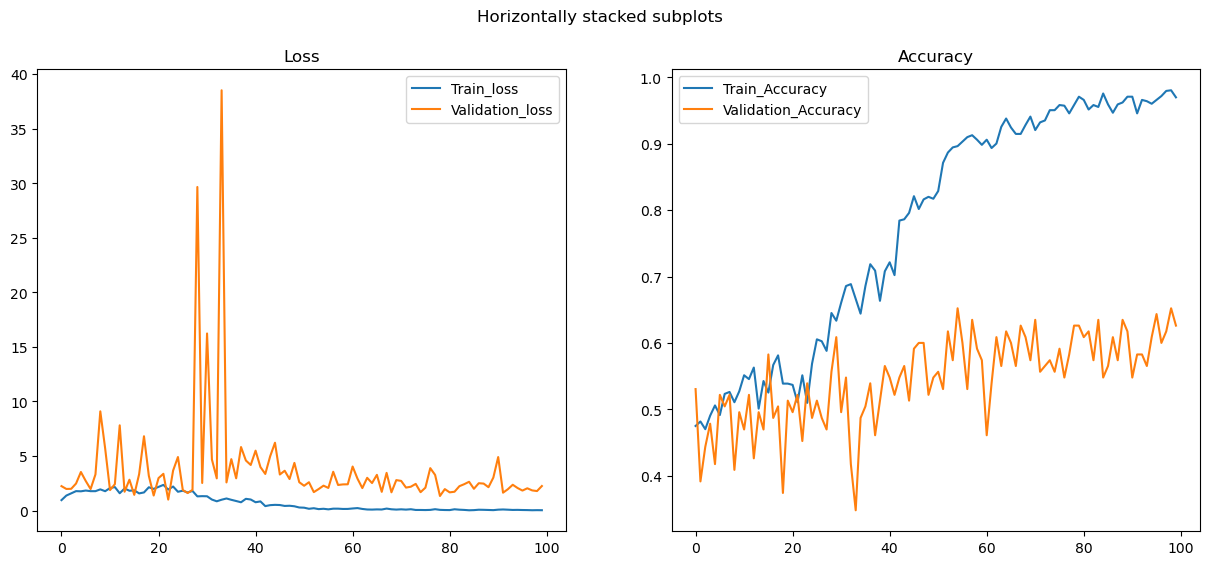

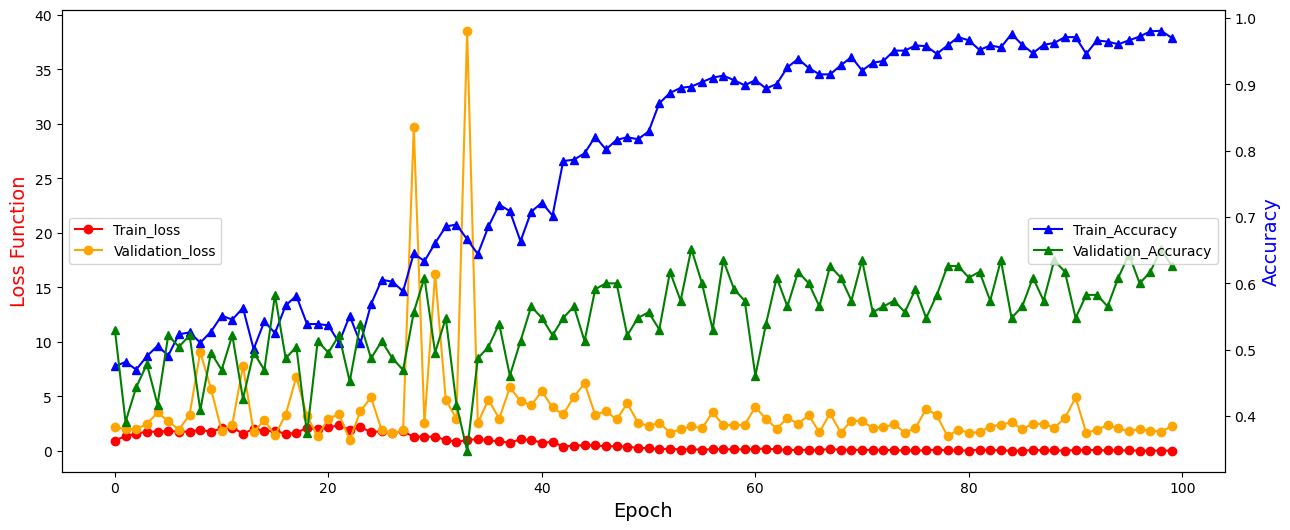

In [19]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

## Save model

In [20]:
# Save Model
NAME2 = "model_2.pt"

torch.save(modelpy, PATH+NAME2)

# Load Last Model

In [21]:
# Load the model
NAME = "model_2.pt"
modelpy = torch.load(PATH+NAME, map_location=device)
modelpy.eval()

ClassificationNet(
  (model_fe): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, moment

## Evaluate Last Model

In [22]:
def accuracy_given_set(mm2, valid_loader, device, name="Validation"):
    # Evaluate the Validation Set
    mm2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            new_images = data[0].to(device)

            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)

            total += data[1].size(0)
            correct +=(predictions == data[1].to(device)).sum().item()
        
    print(f'Accuracy of the network on the {total} {name} instances: {100 * correct / total}%')

In [23]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:37<00:00,  3.43it/s]


Accuracy of the network on the 1034 Train instances: 96.32495164410058%


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]

Accuracy of the network on the 115 Validation instances: 62.608695652173914%


## Test Predictions Last Model

In [24]:
def make_predictions(mm2, loader, device):
    # Evaluate the Validation Set
    mm2.eval()
    predictions_list = []
    name_list = []
    
    with torch.no_grad():
        for bi, data in tqdm(enumerate(loader), total=len(loader)):
            new_images = data[0].to(device)
        
            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)
        
            predictions_list.append(predictions[0].item())
            name_list.append(data[1][0])
        
    return(predictions_list, name_list)

In [25]:
pred, names = make_predictions(modelpy, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:23<00:00, 16.37it/s]


(array([0, 1, 2, 3]), array([175, 146,  56,   3], dtype=int64))

In [26]:
save_predictions_as_csv(names, pred, name="GGCv2_plus_clas_v01_DenseNet_prediction.csv")

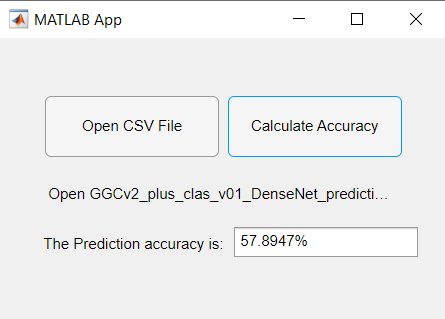

# Load Best Model

In [27]:
# Load the model
NAME = "model_2_bestModel.pt"
modelpy_bestModel = torch.load(PATH+NAME, map_location=device)
modelpy_bestModel.eval()

ClassificationNet(
  (model_fe): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, moment

## Evaluate Best Model

In [28]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy_bestModel, train_loader, device, name="Train")
accuracy_given_set(modelpy_bestModel, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:37<00:00,  3.42it/s]


Accuracy of the network on the 1034 Train instances: 93.7137330754352%


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]

Accuracy of the network on the 115 Validation instances: 65.21739130434783%


## Test Predictions Best Model

In [29]:
pred, names = make_predictions(modelpy_bestModel, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:19<00:00, 19.22it/s]


(array([0, 1, 2, 3]), array([176, 155,  47,   2], dtype=int64))

In [30]:
save_predictions_as_csv(names, pred, name="GGCv2_plus_clas_v01_DenseNet_best_prediction.csv")

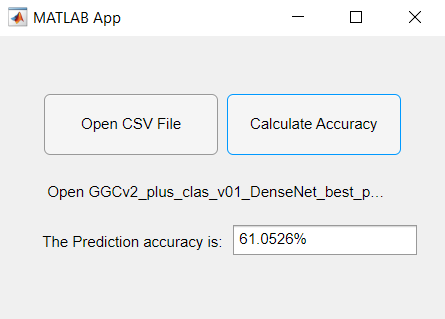